In [1]:
import glob # module for filenames and directory paths
import os
import numpy as np
import torch # import Pytorch framework
from torch import nn, Tensor
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision # for manipulate and process images

from PIL import Image # import Pillow (Python Imaging Library)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Print the current working directory
print("Current working directory:", os.getcwd())

# create a directory prevents an error from being raised if the directory already exists
os.makedirs("Generated", exist_ok=True)
os.makedirs("CheckPoint", exist_ok=True)

Current working directory: c:\Users\baoqt\OneDrive\Documents\GitHub\GenAIExample\Pix2Pix


# 1. Dataset

In [3]:
# Define transform
img_height = 256
img_width = 256

transforms = [
    # Resizes the image to a fixed height and width of 256x256 pixels
    torchvision.transforms.Resize((img_height, img_width), Image.BICUBIC),

    # Converts the PIL Image into a PyTorch Tensor
    # The pixel values will be scaled to the range of [0, 1]
    torchvision.transforms.ToTensor(),

    # Normalizes the image channels (RGB), centers the data around zero and standardizes the range
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

In [4]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms=None, split="train"): # constructor
        # Sets up the desired transformations
        # The Compose object allows you to chain together multiple image transformations that will be applied in sequence
        self.transform = torchvision.transforms.Compose(transforms)

        # Locates your image files based on the root directory and the specified split
        # The list of sorted image paths is stored as an attribute of the dataset object
        self.files = sorted(glob.glob(os.path.join(root, split) + "/*.*"))


    # loading and preprocessing a single image pair when access an element of the dataset
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)]) # open img
        w, h = img.size # get img size

        # creates a cropped copy of a portion of the original img (left, upper, right, lower)
        img_A = img.crop((0, 0, w / 2, h)) # left img
        img_B = img.crop((w / 2, 0, w, h)) # right img

        # data augmentation
        if np.random.random() < 0.5:
            # random flipping horizontally
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB") # [rows, flip column value, color chanel]
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        # Applies the series of image transformations
        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        # Returns a dictionary containing the preprocessed image pair
        return {"A": img_A, "B": img_B}

    def __len__(self): # get the length of the dataset (number of image pairs available)
        return len(self.files)

In [5]:
# Create dataset and applies the image transformations onto each split folder
train_set = ImageDataset(root=f"./Data", transforms=transforms, split="train")
val_set = ImageDataset(root=f"./Data", transforms=transforms, split="val")

# show length of each split
len(train_set), len(val_set)

(856, 202)

In [6]:
# define dataset loader
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 2. Model

In [7]:
# Down sampling using CNN
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__() # Calls the constructor of the parent class
        self.model = nn.Sequential(nn.Conv2d(in_channels, out_channels, # Conv2d is a convolutional layer. Input and output channels as defined in the constructor
                                             kernel_size=4, stride=2, # 4x4 convolution kernel, stride=2 (moving 2 pixel at a time)
                                             padding=1, bias=False), # Adds a padding of 1 pixel around the input to maintain spatial size
                                   nn.LeakyReLU(0.2)) # activation function

    def forward(self, x):
        return self.model(x) # Applies the sequential model to the input

# Up sampling using reversed CNN
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, # nn.ConvTranspose2d is a deconvolutional layer
                                                      kernel_size=4, stride=2,
                                                      padding=1, bias=False),
                                   nn.LeakyReLU(0.2))

    def forward(self, x, skip_input):
        x = self.model(x) # Applies the transposed convolution and activation to perform upsampling
        x = torch.cat((x, skip_input), 1) # Concatenates the upsampled output
        return x

# Define Generator using U-Net architecture
class Generator(nn.Module):
    # The Constructor: Defines network components, sets up structure
    def __init__(self, in_channels=3, out_channels=3): # Indicates that input and output is a RGB img
        super().__init__()

        # Encoder: Progressively downsample and extract higher-level features
        # arguments are in_channels and out_channels. The out_channels increasing from 3 to 512 mean that it reduces the spatial dimension
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
        self.down5 = DownSample(512, 512)
        self.down6 = DownSample(512, 512)
        self.down7 = DownSample(512, 512)
        self.down8 = DownSample(512, 512)

        # Decoder: blocks expand the spatial resolution while incorporating skip connections to recover fine-grained details
        self.up1 = UpSample(512, 512)
        self.up2 = UpSample(1024, 512)
        self.up3 = UpSample(1024, 512)
        self.up4 = UpSample(1024, 512)
        self.up5 = UpSample(1024, 256)
        self.up6 = UpSample(512, 128)
        self.up7 = UpSample(256, 64)

        # Output Layer: block processes the features to produce the final image
        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # Upscales the image spatially by a factor of 2
            nn.ZeroPad2d((1, 0, 1, 0)), # Adds padding asymmetrically to ensure consistency in how the convolution is applied
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1),
            nn.Tanh() # Applies the Tanh activation function, producing outputs likely in the range of -1 to 1
        )

    # Defines data flow and transformations
    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        # Decoder
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        # Final processing
        return self.final(u7)

# Define Discreminator using CNN
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels * 2, 64, kernel_size=4, stride=2, padding=1), # Convolutional Layers (in_channels, out_channels,....)
            nn.LeakyReLU(0.2, inplace=True), # activation

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(128), # instance normalization helps stabilize the training process of GANs

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(512),

            nn.ZeroPad2d((1, 0, 1, 0)), # adds one pixel of zero padding to the top and bottom
            nn.Conv2d(512, 1, kernel_size=4, padding=1),
            nn.Sigmoid() # This forces the final output to be between 0 and 1, interpretable as the probability that the input is real
        )
    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1) # Concatenates two input images, This doubles the number of input channels
        return self.model(img_input)

In [8]:
# Create model object and move to device

generator = Generator() #create class
generator.to(device) #moves the model to a specified device

discriminator = Discriminator() #create class
discriminator.to(device) #moves the model to a specified device

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (13): Sigmoid()
  )
)

# 3. Training

In [16]:
# Saves a generated sample from the validation set

def sample_images(epoch_done): # takes an epoch number (epoch_done) as input
    imgs = next(iter(val_loader)) # fetches a batch of images from the validation loader (val_loader)
    real_A = imgs["B"][2:7, ...].to(device) #extracts the first 5 images from the "A" domain (real_A) and the "B" domain (real_B)
    real_B = imgs["A"][2:7, ...].to(device)
    fake_B = generator(real_A) # feeds the real_A images to the generator to produce fake images in the "B" domain (fake_B)
    img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) #concatenates the real images (real_A, real_B) and the generated images (fake_B) for comparison.
    save_image(img_sample, f"Generated/epoch_{epoch_done}.png", nrow=5, normalize=True) #save img

save_interval = 5 #controls how frequently the sample_images function is called

In [17]:
EPOCHS = 300

# Set optimizer and learning rate
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

# Set loss function
criterion = torch.nn.BCELoss() # binary cross entropy
criterion_pixelwise = torch.nn.L1Loss() # L1 = mean absolute error

lambda_pixel = 100 # hyper parameter for later use
patch = (1, img_height // 2 ** 4, img_width // 2 ** 4) # devide img into small patch (by 16)

# create dictionary for later visualization
hist = {
        "train_G_loss": [],
        "train_D_loss": [],
    }

for epoch in range(EPOCHS):
    running_G_loss = 0.0
    running_D_loss = 0.0

    for i, batch in enumerate(train_loader):

        real_imgs_A = batch["B"].to(device) # the signal image (mask)
        real_imgs_B = batch["A"].to(device) # the image (facade)

        # prepare labels
        valid = torch.ones(real_imgs_A.size(0), *patch).to(device) # real label, gradualy go to 1
        fake = torch.zeros(real_imgs_A.size(0), *patch).to(device) # fake label, gradualy go to 0

        # --- Train Generator ---
        optimizer_G.zero_grad()

        fake_imgs_B = generator(real_imgs_A) # try to generate new facade image (fake_imgs_B) with signal (real_imgs_A)
        pred_fake = discriminator(fake_imgs_B, real_imgs_A) # pred_fake is the probability value of generated img (fake_imgs_B) with signal (real_imgs_A), this value gradualy go to 1 meaning that the generated img become real

        # Generator loss
        G_loss_GAN = criterion(pred_fake, valid) # GAN loss
        G_loss_pixel = criterion_pixelwise(fake_imgs_B, real_imgs_B) # Pixel-wise loss
        G_loss = G_loss_GAN + lambda_pixel * G_loss_pixel # Total loss

        running_G_loss += G_loss.item()
        G_loss.backward()
        optimizer_G.step()

        # --- Train Discriminator ---
        optimizer_D.zero_grad()

        # train with real data
        pred_real = discriminator(real_imgs_B, real_imgs_A) # pred_real is the probability value of the real_imgs_B with with signal (real_imgs_A)
        loss_real = criterion(pred_real, valid) # real label, gradualy go to 1

        pred_fake = discriminator(fake_imgs_B.detach(), real_imgs_A) # pred_fake is the probability value of the fake_imgs_B with with signal (real_imgs_A)
        loss_fake = criterion(pred_fake, fake) # fake label, gradualy go to 0


        D_loss = (loss_real + loss_fake) / 2 # Total loss

        running_D_loss += D_loss.item()
        D_loss.backward()
        optimizer_D.step()


    epoch_G_loss = running_G_loss / len(train_loader)
    epoch_D_loss = running_D_loss / len(train_loader)

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train G Loss: {epoch_G_loss:.4f}, Train D Loss: {epoch_D_loss:.4f}")

    hist["train_G_loss"].append(epoch_G_loss)
    hist["train_D_loss"].append(epoch_D_loss)

    # save images
    if epoch % save_interval == 0:
        sample_images(epoch)

    # save best parameters
    best_G_loss = float('inf')
    best_D_loss = float('inf')

    if epoch_G_loss < best_G_loss:
        best_G_loss = epoch_G_loss
        torch.save(generator.state_dict(), f"CheckPoint/best_generator_weights.pt")

    if epoch_D_loss < best_D_loss:
        best_D_loss = epoch_D_loss
        torch.save(discriminator.state_dict(), f"CheckPoint/best_discriminator_weights.pt")

Epoch [1/300], Train G Loss: 21.4878, Train D Loss: 0.0945
Epoch [2/300], Train G Loss: 19.1450, Train D Loss: 0.0305
Epoch [3/300], Train G Loss: 18.5786, Train D Loss: 0.0364
Epoch [4/300], Train G Loss: 17.8728, Train D Loss: 0.0709
Epoch [5/300], Train G Loss: 17.2604, Train D Loss: 0.0476
Epoch [6/300], Train G Loss: 18.0064, Train D Loss: 0.0555
Epoch [7/300], Train G Loss: 16.6515, Train D Loss: 0.0265
Epoch [8/300], Train G Loss: 17.9519, Train D Loss: 0.0525
Epoch [9/300], Train G Loss: 16.7852, Train D Loss: 0.0423
Epoch [10/300], Train G Loss: 17.5213, Train D Loss: 0.0496
Epoch [11/300], Train G Loss: 17.4989, Train D Loss: 0.0266
Epoch [12/300], Train G Loss: 18.3640, Train D Loss: 0.0204
Epoch [13/300], Train G Loss: 17.5954, Train D Loss: 0.0075
Epoch [14/300], Train G Loss: 18.2404, Train D Loss: 0.0181
Epoch [15/300], Train G Loss: 17.6913, Train D Loss: 0.0149
Epoch [16/300], Train G Loss: 18.1316, Train D Loss: 0.0053
Epoch [17/300], Train G Loss: 18.6430, Train D Lo

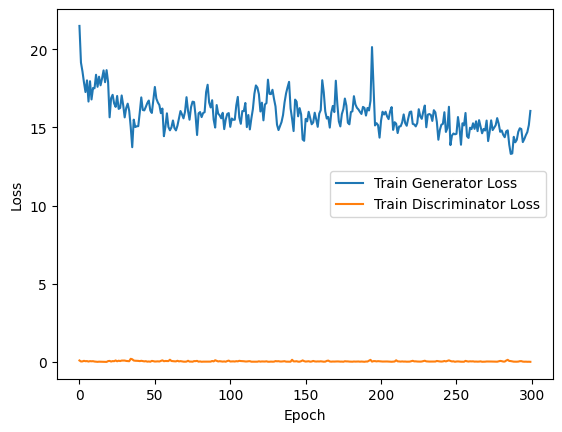

In [18]:
# prompt: visualize the loss, hist dict in the cell before

import matplotlib.pyplot as plt

# Plot training losses
plt.plot(hist["train_G_loss"], label="Train Generator Loss")
plt.plot(hist["train_D_loss"], label="Train Discriminator Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# 4. Testing

In [19]:
class ImageTest(Dataset):
    def __init__(self, root, transforms=None): # constructor
        # Sets up the desired transformations
        # The Compose object allows you to chain together multiple image transformations that will be applied in sequence
        self.transform = torchvision.transforms.Compose(transforms)

        # Locates your image files based on the root directory and the specified split
        # The list of sorted image paths is stored as an attribute of the dataset object
        self.files = sorted(glob.glob(os.path.join(root) + "/*.*"))

        # Extract just the filenames from the full paths
        self.img_names = [os.path.basename(file) for file in self.files]


    # loading and preprocessing a single image pair when access an element of the dataset
    def __getitem__(self, index):
        img_test = Image.open(self.files[index % len(self.files)]) # open img
        img_test = self.transform(img_test) # Applies the series of image transformations
        img_name = self.img_names[index % len(self.img_names)] # Get corresponding image name
        return {"C": img_test, "img_name": img_name}  # Return image and name

    def __len__(self): # get the length of the dataset (number of image pairs available)
        return len(self.files)

In [20]:
# Create dataset
test_set = ImageTest(root=f"./TestInput", transforms=transforms)

# show length of each split
print(len(test_set))
print(type(test_set))

417
<class '__main__.ImageTest'>


In [21]:
# Load the best models
generator = Generator()
generator.load_state_dict(torch.load(f"CheckPoint/best_generator_weights.pt"))

discriminator = Discriminator()
discriminator.load_state_dict(torch.load(f"CheckPoint/best_discriminator_weights.pt"))

# Move models to device

generator.to(device)
discriminator.to(device)

# Define test loader
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)

# Create result folder
os.makedirs("TestResult", exist_ok=True)

# Test the model
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        real_imgs_C = batch["C"].to(device)
        fake_imgs_B = generator(real_imgs_C)
        final_img = fake_imgs_B.data

        img_name = batch["img_name"][0]  # Get the image name from the batch when batch size is 1
        save_image(final_img, f"TestResult/Result_{img_name}", nrow=1, normalize=True)

